In [1]:
import os
import smtplib
import requests
import pandas as pd
import numpy as np

from email.message import EmailMessage
from matplotlib import dates as mdates
from matplotlib import pyplot as plt
from dotenv import load_dotenv
import yfinance as yf
from bloxs import B

plt.style.use('ggplot')

_ = load_dotenv() 

In [2]:
stock_symbol = "TSLA"
crypto_symbol = "BTC"

In [4]:

class EmailService:
    def __init__(self):
        self.address = os.environ.get("EMAIL_ADDRESS")
        self.password = os.environ.get("EMAIL_PASSWORD")
        
    def send(self, to_address, subject, message):
        msg = EmailMessage()
        msg['Subject'] = subject
        msg['From'] = self.address
        msg['To'] = to_address
        msg.set_content(message)
        
        with smtplib.SMTP_SSL('smtp.gmail.com', 465) as smtp:
            smtp.login(self.address, self.password)
            smtp.send_message(msg)

In [5]:
# get stock data from Yahoo Finance
stock = yf.Ticker(stock_symbol)
stock_hist = stock.history()

In [24]:
# get crypto data from Binance REST API
def get_crypto_data(symbol):
    try:
        response = requests.get(f"https://www.binance.com/api/v1/klines?symbol={symbol}&interval=1d&limit=30")
        candles = response.json()
        df = pd.DataFrame(candles, columns=["Open time", "Open", "High", "Low", "Close", "Volume", 
                                        "Close time", "Quote", "Trades", "BaseVol", "QuoteVol", "Igonre"])
        df["Date"] = pd.to_datetime(df["Open time"], unit='ms')
        for col in ["Open", "High", "Low", "Close", "Volume"]:
            df[col] = df[col].astype(float)
        df = df.set_index('Date')
        return df
    except Exception as e:
        print(str(e))
        return None
    
crypto = get_crypto_data(f"{crypto_symbol}USDT")

In [7]:
# get weather data from open meteo REST API
def get_meteo_data(lat = 40.6824408, lon=14.7680961):
    try:
        url = f"https://api.open-meteo.com/v1/forecast?latitude={lat}&longitude={lon}&hourly=temperature_2m,windspeed_10m,windgusts_10m&windspeed_unit=kn&timezone=Europe%2FBerlin"
        data = requests.get(url).json()
        meteo = pd.DataFrame(data["hourly"])
        meteo.time = pd.to_datetime(meteo.time)
        return meteo
    except Exception as e:
        print(str(e))
        return None

meteo = get_meteo_data()

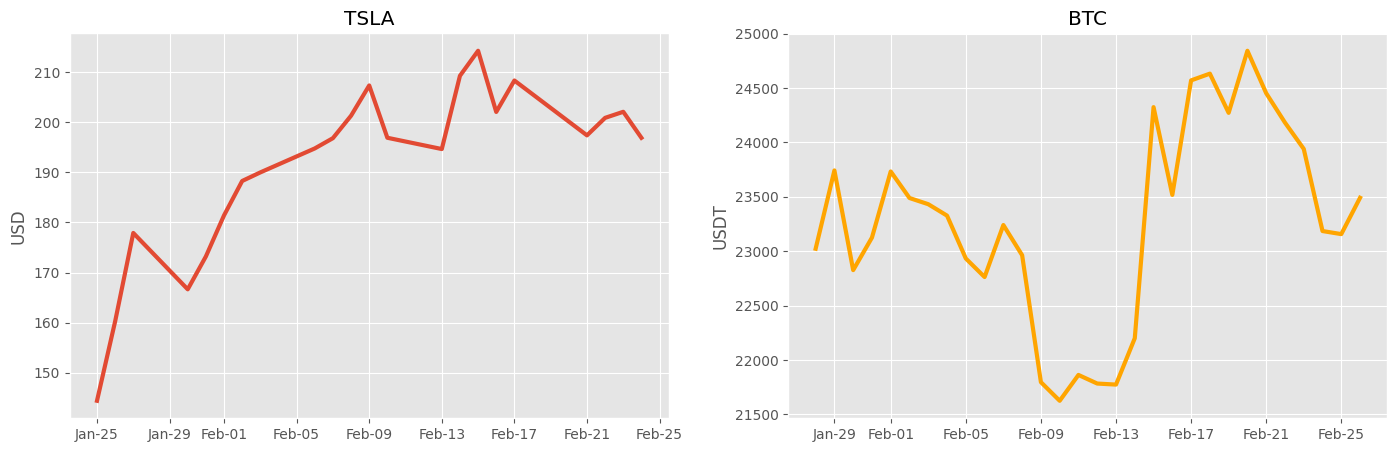

In [25]:
# plot finance charts
fig, ax = plt.subplots(1, 2, figsize=(17,5))

_ = ax[0].plot(stock_hist.Close,  linewidth=3)
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
_=ax[0].set_ylabel("USD")
ax[0].title.set_text(stock_symbol)


_=ax[1].plot(crypto.Close, color="orange", linewidth=3)
ax[1].title.set_text(crypto_symbol)
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
_=ax[1].set_ylabel("USDT")


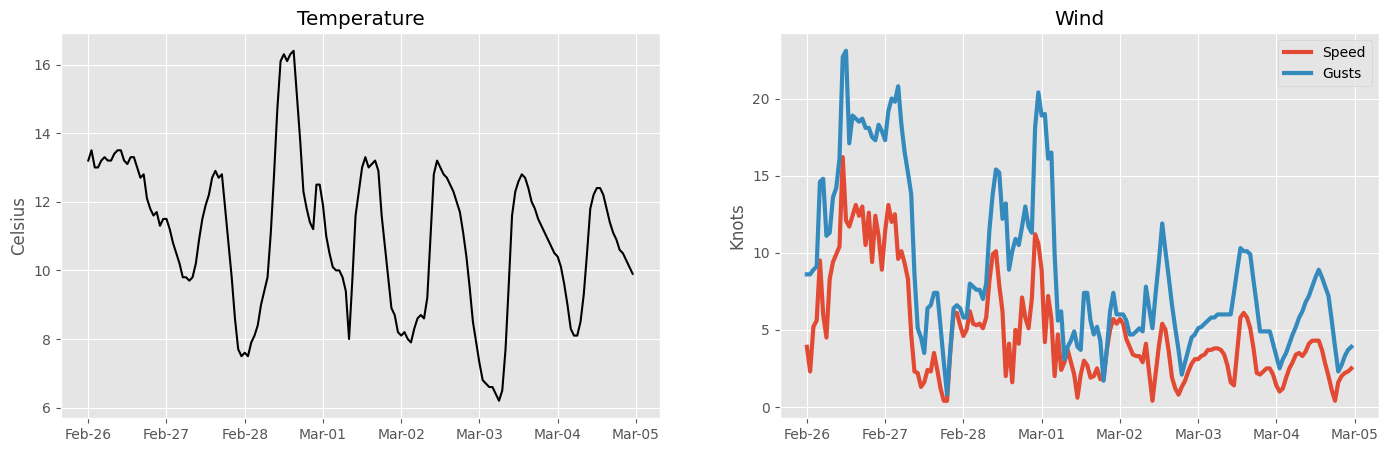

In [9]:
# plot meteo charts
fig, ax = plt.subplots(1, 2, figsize=(17,5))

_=ax[0].plot(meteo.time, meteo.temperature_2m, color="black")
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
ax[0].set_ylabel("Celsius")
ax[0].title.set_text("Temperature")

_=ax[1].plot(meteo.time, meteo.windspeed_10m, label="Speed", linewidth=3)
_=ax[1].plot(meteo.time, meteo.windgusts_10m, label="Gusts", linewidth=3)
_=ax[1].title.set_text("Wind")
_=ax[1].set_ylabel("Knots")
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
_=ax[1].legend()

In [21]:
# alerts

In [10]:
if meteo.windgusts_10m.max() > 25:
    EmailService().send("ithinkdiabolik@gmail.com", 
        "Strong wind gusts alert", 
        f"There might be strong wind gusts in the next 7 days. Up to {meteo.windgusts_10m.max()} knots.")

In [11]:
stock_change = (stock_hist.tail(7).Close.max() - stock_hist.tail(7).Close.min())/stock_hist.tail(7).Close.max()

In [12]:
if stock_change > 0.3: # stock change over 30% send email notification
    EmailService().send("ithinkdiabolik@gmail.com", 
        "Stock large price change alert", 
        f"Large price change ({np.round(stock_change*100.0,2)}%) of {stock_symbol} in the last 7 days.")

In [26]:
crypto_change = (crypto.tail(7).Close.max() - crypto.tail(7).Close.min())/crypto.tail(7).Close.max()

In [14]:
if crypto_change > 0.3: # crypto change over 30% send email notification
    EmailService().send("ithinkdiabolik@gmail.com", 
        "Crypto price large change alert", 
        f"Large price change ({np.round(crypto_change*100.0,2)}%) of {crypto_symbol} in the last 7 days.")

In [21]:
B([
    B(f"{np.round(stock_change*100, 2)}%", f"{stock_symbol} week change"),
    B(f"{np.round(crypto_change*100, 2)}%", f"{crypto_symbol} week change"),
    B(meteo.windgusts_10m.max(), f"Max wind gusts"),
])

In [27]:
B([
    B(stock_hist.Close[-1].astype(int), f"{stock_symbol}"),
    B(crypto.Close[-1].astype(int), f"{crypto_symbol}"),
    B(meteo.temperature_2m.max(), f"Max Temp"),
])